# Basketball-Reference Scraper Overview
After scraping the data (see: [basketball-reference-scraper.ipynb](https://github.com/rahim-hashim/NBA-Prediction-Algorithms/blob/df_version/basketball-reference-scraper.ipynb)), you'll have 3 DataFrames saved as a [pickle file](https://docs.python.org/3/library/pickle.html) which you can upload:

1. **df_players_meta**
  * biodata (i.e. height, age, weight)
2. **df_players_data**
  * season data (per-game, total, per-possesion)
3. **df_players_gamelogs**
  * gamelogs for all players

***
## Import


In [1]:
%reload_ext autoreload
import os
import sys
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict, defaultdict
pd.options.mode.chained_assignment = None  # default='warn'

## Path Assignment

In [2]:
ROOT = os.getcwd() #@param ['/content/drive/MyDrive/Projects/nba-prediction-algorithm/NBA-Prediction-Algorithms/']  

# add (non-Python) helper functions
def add_helpers():
  '''
  add_helper mounts google drive and adds
  helper functions to the sys.path
  '''

  # if running on juypter/google colab, mount to google drive
  if 'google.colab' in str(get_ipython()): 
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    os.chdir(ROOT)

  helper_dir_path = os.path.join(ROOT,'helper')
  print('\nHelpers:')
  pprint(sorted(os.listdir(helper_dir_path)))
  sys.path.append(helper_dir_path) # set to path of notebook

add_helpers()


Helpers:
['Regions.py',
 '__pycache__',
 'betting',
 'data',
 'fuzzy_lookup.py',
 'game_log_scraper.py',
 'lineup_scraper.py',
 'matchup_plots',
 'metaAnalysis.py',
 'meta_info_scraper.py',
 'parse_tools.py',
 'player_info_scraper.py',
 'player_matchup.py',
 'player_scraper.py',
 'player_table_scraper.py',
 'plot_helper',
 'stat_info.py',
 'stat_printer.py',
 'teamsScraper.py',
 'test_functions.py']


***
## Pickle Loading
“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream. Here we will "unpickle" i.e. reload the data that we pickled during the scraping.<br>
>For documentation on pickle: https://docs.python.org/3/library/pickle.html

In [3]:
from player_scraper import pickle_load

DATA_PATH = os.path.join(ROOT,'data')
sys.path.append(DATA_PATH)
pprint(sorted(os.listdir(DATA_PATH)))

players_df_meta = pickle_load(os.path.join(DATA_PATH,'players_df_meta.pkl'))
players_df_data = pickle_load(os.path.join(DATA_PATH,'players_df_data.pkl'))
players_df_gamelogs = pickle_load(os.path.join(DATA_PATH,'players_df_gamelogs.pkl'))

['jersey_df.pkl',
 'players_df_data.pkl',
 'players_df_gamelogs.pkl',
 'players_df_meta.pkl']


In [4]:
print('players_df_meta:\n {}'.format(players_df_meta.columns))
print('players_df_data:\n {}'.format(players_df_data.columns))
print('players_df_gamelogs:\n {}'.format(players_df_gamelogs.columns))

players_df_meta:
 Index(['player_name', 'draft_year', 'retire_year', 'height', 'weight',
       'birth_date', 'college', 'shootingHand', 'highSchool', 'highSchoolCity',
       'highSchoolState', 'highSchoolCountry', 'draftTeam', 'draftRound',
       'draftRoundPick', 'draftOverallPick'],
      dtype='object')
players_df_data:
 Index(['data_type', 'season_playoffs', 'player_name', 'season', 'age',
       'team_id', 'lg_id', 'pos', 'g', 'gs',
       ...
       'pct_fga_dunk', 'fg_dunk', 'pct_fg3a_corner3', 'fg_pct_corner3',
       'fg3a_heave', 'fg3_heave', 'college_id', 'team_name', 'salary',
       'trp_dbl'],
      dtype='object', length=149)
players_df_gamelogs:
 Index(['player_name', 'season', 'season_playoffs', 'rk', 'g', 'date', 'age',
       'tm', 'loc', 'opp', 'win', 'gs', 'mp', 'fg', 'fga', 'fg%', 'ft', 'fta',
       'ft%', 'trb', 'ast', 'pf', 'pts', 'note', '3p', '3pa', '3p%', 'orb',
       'drb', 'stl', 'blk', 'tov', 'gmsc', 'plus_minus'],
      dtype='object')


***
## Biometrics Data

Basic analyses on biometrics data.<br>
> Example Overview Source (last name starting with a): https://www.basketball-reference.com/players/a/<br>

In [7]:
players_df_meta[players_df_meta['weight'] == max(players_df_meta['weight'])]

,player_name,draft_year,retire_year,height,weight,birth_date,college,shootingHand,highSchool,highSchoolCity,highSchoolState,highSchoolCountry,draftTeam,draftRound,draftRoundPick,draftOverallPick
0,Sim Bhullar,2015,2015,89,360,"December 2, 1992",New Mexico State,Right,Huntington Prep,Huntington,West Virginia,United States of America,NaN,NaN,NaN,NaN


## Draft Data

In [ ]:
pd.set_option('display.max_rows', 999)
players_df_meta[players_df_meta['draftOverallPick'] == 1].sort_values(by='draft_year', ascending=True)

In [ ]:
from metaAnalysis import metaPlot, geographyPlot
        
metaPlot(players_df_meta)
geographyPlot(players_df_meta)

***
## Season Data

Analyses on season-wide stats. You can use widgets to filter data, as an example below:

In [30]:
#@title Table Select { run: "auto" }

#@markdown Per Game | Totals | Advanced | Per Minute | Per Possession | Adjusted Shooting | Play-By-Play | Shooting | All-Star | Salaries
table_type = "per_game" #@param ["all", "per_game", "totals", "advanced", "per_minute", "per_poss", "adjooting", "pbp", "shooting", "all_star", "all_salaries"] {allow-input: true}

#@markdown Season or Playoff Stats
season_playoffs = "season" #@param ["both", "season", "playoffs"]

#@markdown Include or Exclude Career Data
career_data = "exclude" #@param ["include", "exclude"]

#@markdown Minimum Games
min_games = None #@param {type:"integer"}

#@markdown Minimum Year
year_min = None #@param {type:"string"}

#@ Team Selection
team_id = None #@param {type:"string"}

def table_select(df, table_type, season_playoffs):
  df_filtered = df.copy(deep=True)
  if table_type != 'all':
    df_filtered = df[df['data_type'] == table_type]
    df_filtered = df_filtered.dropna(how='all', axis='columns')
  if season_playoffs != 'both':
    df_filtered = df_filtered[df_filtered['season_playoffs'] == season_playoffs]
  
  if career_data == 'exclude':
    df_filtered = df_filtered[df_filtered['season'] != 'Career']

  if min_games and min_games > 0:
    df_filtered = df_filtered[df_filtered['g'] >= min_games]
  if year_min:
    df_filtered = df_filtered[df_filtered['season'] >= year_min]
  if team_id:
    df_filtered = df_filtered[df_filtered['team_id'] == team_id]
  
  return df_filtered

table_selected = table_select(players_df_data, table_type, season_playoffs)
print('Columns: \n{}'.format(list(table_selected.columns)))

Columns: 
['data_type', 'season_playoffs', 'player_name', 'season', 'age', 'team_id', 'lg_id', 'pos', 'g', 'gs', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'trb_per_g', 'ast_per_g', 'pf_per_g', 'pts_per_g', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'efg_pct', 'orb_per_g', 'drb_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'jersey_num']


In [191]:
stat = 'fg_dunk'
table_selected.sort_values(by=stat, ascending=False).head(10)[['player_name', 'team_id', 'g', 'season', stat]]

,player_name,team_id,g,season,fg_dunk
151741,Rudy Gobert,UTA,81.0,2018-19,306.0
151878,Giannis Antetokounmpo,MIL,72.0,2018-19,279.0
279933,Dwight Howard,ORL,82.0,2007-08,269.0
23561,Shaquille O'Neal,MIA,73.0,2004-05,255.0
279932,Dwight Howard,ORL,82.0,2006-07,254.0
266901,DeAndre Jordan,LAC,81.0,2016-17,253.0
266899,DeAndre Jordan,LAC,82.0,2014-15,252.0
23558,Shaquille O'Neal,LAL,67.0,2001-02,252.0
23559,Shaquille O'Neal,LAL,67.0,2002-03,251.0
266898,DeAndre Jordan,LAC,82.0,2013-14,245.0


***
## Gamelogs

Analyses on gamelog stats.

In [ ]:
players_df_gamelogs[players_df_gamelogs['pts']==np.nanmax(players_df_gamelogs['pts'])]

,player_name,season,season_playoffs,rk,g,date,age,tm,loc,opp,...,3p,3pa,3p%,orb,drb,stl,blk,tov,gmsc,plus_minus
75,Wilt Chamberlain,1961-62,season,76,76.0,1962-03-02,25-193,PHW,NaN,NYK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from player_matchup import matchup_game_finder

print(players_df_gamelogs.columns)

player = 'Kobe Bryant'
opponent = 'Tony Allen'
df_overlap = matchup_game_finder(players_df_gamelogs, player, opponent)
print(np.nanmean(df_overlap['pts']))

47 games found
Index(['player_name', 'season', 'season_playoffs', 'rk', 'g', 'date', 'age',
       'tm', 'loc', 'opp', 'win', 'gs', 'mp', 'fg', 'fga', 'fg%', 'ft', 'fta',
       'ft%', 'trb', 'ast', 'pf', 'pts', 'note', '3p', '3pa', '3p%', 'orb',
       'drb', 'stl', 'blk', 'tov', 'gmsc', 'plus_minus'],
      dtype='object')
26.463414634146343


***
# Betting Lines

In [ ]:
from betting.helper import bettingLinesScraper

start_year = 2010 #@param {type:"integer"}
end_year = 2022 #@param {type:"integer"}

betting_lines_dict = bettingLinesScraper.scrape(start_year, end_year)
betting_lines_df = pd.DataFrame.from_dict(betting_lines_dict)

Years:   0%|          | 0/12 [00:00<?, ?it/s]

Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2010...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2011...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2012...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2013...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2014...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2015...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2016...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2017...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2018...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2019...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2020...
Getting conference lists ...


Teams:   0%|          | 0/38 [00:00<?, ?it/s]

Initializing Records for 2021...
Getting conference lists ...


***
## Jersey Number Analysis

In [8]:
from helper.player_scraper import pickle_load

jersey_pkl_path = os.path.join(DATA_PATH,'jersey_df.pkl')
jersey_df = pickle_load(jersey_pkl_path)

In [9]:
from helper.betting import TeamNames
from tqdm.notebook import tqdm

team_abbv_dict = defaultdict(list)
# flip key, value pairs in teamDict while maintaining multiple values per key
for key, value in TeamNames.teamDict.items():
    team_abbv_dict[value].append(key)

# Initialize jersey column in dataframe to np.nan
players_df_data['jersey_num'] = np.nan
# Reset index to make it easier to iterate through dataframe
players_df_data = players_df_data.reset_index(drop=True)

print('Total number of unique player/jersey combinations: {}'.format(len(jersey_df)))
print('Total number of players: {}'.format(len(players_df_data['player_name'].unique())))

for row in tqdm(jersey_df.itertuples()):
    player, team, year, jersey_number = row.player, row.team, row.year, row.jersey_number
    for team_abbv in team_abbv_dict[team]:
        df_player = players_df_data[(players_df_data['player_name'] == player) & 
                                    (players_df_data['season'] == year) &
                                    (players_df_data['team_id'] == team_abbv)]
        if not df_player.empty:
            for index, row in df_player.iterrows():
                players_df_data.loc[index, 'jersey_num'] = jersey_number

Total number of unique player/jersey combinations: 28359
Total number of players: 4976


0it [00:00, ?it/s]

In [10]:
players_df_data[['player_name', 'season', 'jersey_num']].head(10)

,player_name,season,jersey_num
0,Joe Fabel,1946-47,NaN
1,Joe Fabel,Career,NaN
2,Joe Fabel,1946-47,NaN
3,Joe Fabel,Career,NaN
4,Joe Fabel,1946-47,NaN
5,Joe Fabel,Career,NaN
6,Joe Fabel,1946-47,NaN
7,Joe Fabel,Career,NaN
8,Edwin Ubiles,2011-12,1
9,Edwin Ubiles,Career,NaN


In [33]:
table_type = "per_game" #@param ["all", "per_game", "totals", "advanced", "per_minute", "per_poss", "adjooting", "pbp", "shooting", "all_star", "all_salaries"] {allow-input: true}
season_playoffs = "season" #@param ["both", "season", "playoffs"]
table_selected = table_select(players_df_data, table_type, season_playoffs)
print('Columns: \n{}'.format(list(table_selected.columns)))

Columns: 
['data_type', 'season_playoffs', 'player_name', 'season', 'age', 'team_id', 'lg_id', 'pos', 'g', 'gs', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'trb_per_g', 'ast_per_g', 'pf_per_g', 'pts_per_g', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'efg_pct', 'orb_per_g', 'drb_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'jersey_num']


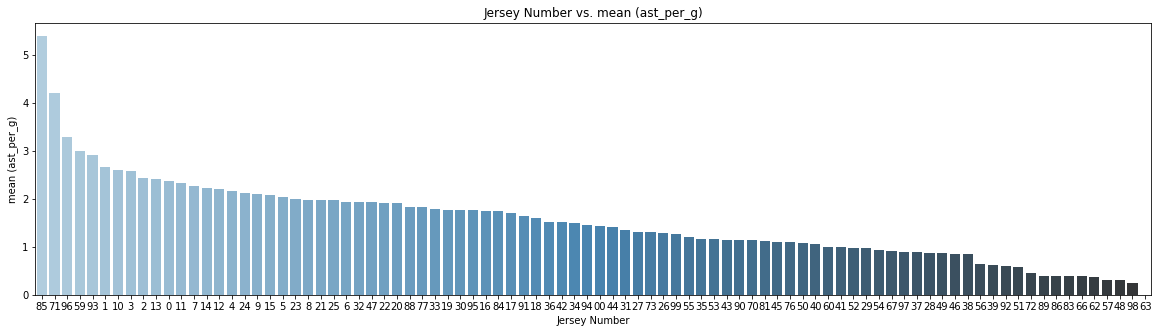

In [35]:
import seaborn as sns
from IPython.display import display
stat = 'ast_per_g'
jersey_num = table_selected.groupby('jersey_num').mean()[stat].sort_values(ascending=False).index
ws = table_selected.groupby('jersey_num').mean()[stat].sort_values(ascending=False).values

f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(ax=ax, x=jersey_num, y=ws, palette='Blues_d')
# plt.xticks(range(len(jersey_num)), jersey_num, rotation=45)
ax.set_xlabel('Jersey Number')
ax.set_ylabel('mean ({})'.format(stat))
plt.title('Jersey Number vs. mean ({})'.format(stat))
plt.show()

# vaporwave colors
colors = ['#a8ff78', '#78ffd6', '#c6c5fe', '#ff8efb', '#ff8e8e']

In [195]:
table_selected[table_selected['jersey_num'] == '21'].sort_values(by=stat, ascending=False)[['player_name', 'season', 'jersey_num', stat]].head(20)

,player_name,season,jersey_num,fg_dunk
208111,Hassan Whiteside,2016-17,21,163.0
6245,Daniel Gafford,2021-22,21,158.0
208113,Hassan Whiteside,2018-19,21,151.0
252766,Tim Duncan,1997-98,21,149.0
208110,Hassan Whiteside,2015-16,21,148.0
47225,Kevin Garnett,1997-98,21,131.0
208114,Hassan Whiteside,2019-20,21,128.0
37296,Marcus Camby,1996-97,21,127.0
220839,J.J. Hickson,2012-13,21,122.0
220834,J.J. Hickson,2009-10,21,117.0


In [178]:
table_selected[(table_selected['player_name'] == 'Chris Webber') & (table_selected['season'] == '2006-07')]

,data_type,season_playoffs,player_name,season,age,team_id,lg_id,pos,g,mp,...,fg3a_per_fga_pct,stl_pct,blk_pct,tov_pct,usg_pct,obpm,dbpm,bpm,vorp,jersey_num
142159,advanced,season,Chris Webber,2006-07,33.0,TOT,NBA,PF,61.0,1821,...,0.017,1.8,1.7,13.1,21.1,0.0,1.0,1.0,1.4,NaN
142160,advanced,season,Chris Webber,2006-07,33.0,PHI,NBA,PF,18.0,544,...,0.022,1.8,2.1,12.0,23.4,-1.2,0.4,-0.7,0.2,4
142161,advanced,season,Chris Webber,2006-07,33.0,DET,NBA,PF,43.0,1277,...,0.015,1.8,1.6,13.7,20.2,0.5,1.2,1.7,1.2,84
